In [1]:
import random
from scipy import stats
import sklearn.impute as imp
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import time
import timeit

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress = True)

In [3]:
df = pd.read_csv("CountyHealth.csv")

In [4]:
i = 1
for c in df.columns:
    print ("Variable", i, ": ", c)
    i+=1

Variable 1 :  FIPS
Variable 2 :  State
Variable 3 :  County
Variable 4 :  Years of Potential Life Lost Rate
Variable 5 :  YPLL Rate (White)
Variable 6 :  % Fair/Poor
Variable 7 :  Physically Unhealthy Days
Variable 8 :  Mentally Unhealthy Days
Variable 9 :  % LBW
Variable 10 :  % Smokers
Variable 11 :  % Obese
Variable 12 :  Food Environment Index
Variable 13 :  % Physically Inactive
Variable 14 :  % With Access
Variable 15 :  % Excessive Drinking
Variable 16 :  # Alcohol-Impaired Driving Deaths
Variable 17 :  # Driving Deaths
Variable 18 :  % Alcohol-Impaired
Variable 19 :  # Chlamydia Cases
Variable 20 :  Chlamydia Rate
Variable 21 :  Teen Birth Rate
Variable 22 :  # Uninsured
Variable 23 :  % Uninsured
Variable 24 :  # Primary Care Physicians
Variable 25 :  PCP Rate
Variable 26 :  PCP Ratio
Variable 27 :  # Dentists
Variable 28 :  Dentist Rate
Variable 29 :  Dentist Ratio
Variable 30 :  # Mental Health Providers
Variable 31 :  MHP Rate
Variable 32 :  MHP Ratio
Variable 33 :  Prevent

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 67 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FIPS                               3142 non-null   int64  
 1   State                              3142 non-null   object 
 2   County                             3142 non-null   object 
 3   Years of Potential Life Lost Rate  2908 non-null   float64
 4   YPLL Rate (White)                  1579 non-null   float64
 5   % Fair/Poor                        3142 non-null   int64  
 6   Physically Unhealthy Days          3142 non-null   float64
 7   Mentally Unhealthy Days            3142 non-null   float64
 8   % LBW                              3035 non-null   float64
 9   % Smokers                          3142 non-null   int64  
 10  % Obese                            3142 non-null   int64  
 11  Food Environment Index             3123 non-null   float

In [6]:
# State and County can be mapped back to FIPS for display purposes, but we don't need them for analysis
# Columns 15, 18, 21, 23, 26, 29, 37, 40, 44, 45, 46, 47, 49, 52, 54, 56, 61, 62, 63 and 65 are redundant with other columns
# that already represent that data in another form
# Columns 3, 4, 58 and 59 contain many NULLs
# 16, 35, 41 and 50 are all 90+% correlated with the population - kept population and dropped 

dcols = [1, 2, 3, 4, 15, 16, 18, 21, 23, 26, 29, 35, 37, 40, 41, 44, 45, 46, 47, 49, 50, 52, 54, 56, 58, 59, 61, 62, 63, 65]
df2 = df.drop(df.columns[dcols], axis=1)

# Save FIPS codes, States and Counties
FIPS_Series = df2["FIPS"]
State_Series = df["State"]
County_Series = df["County"]

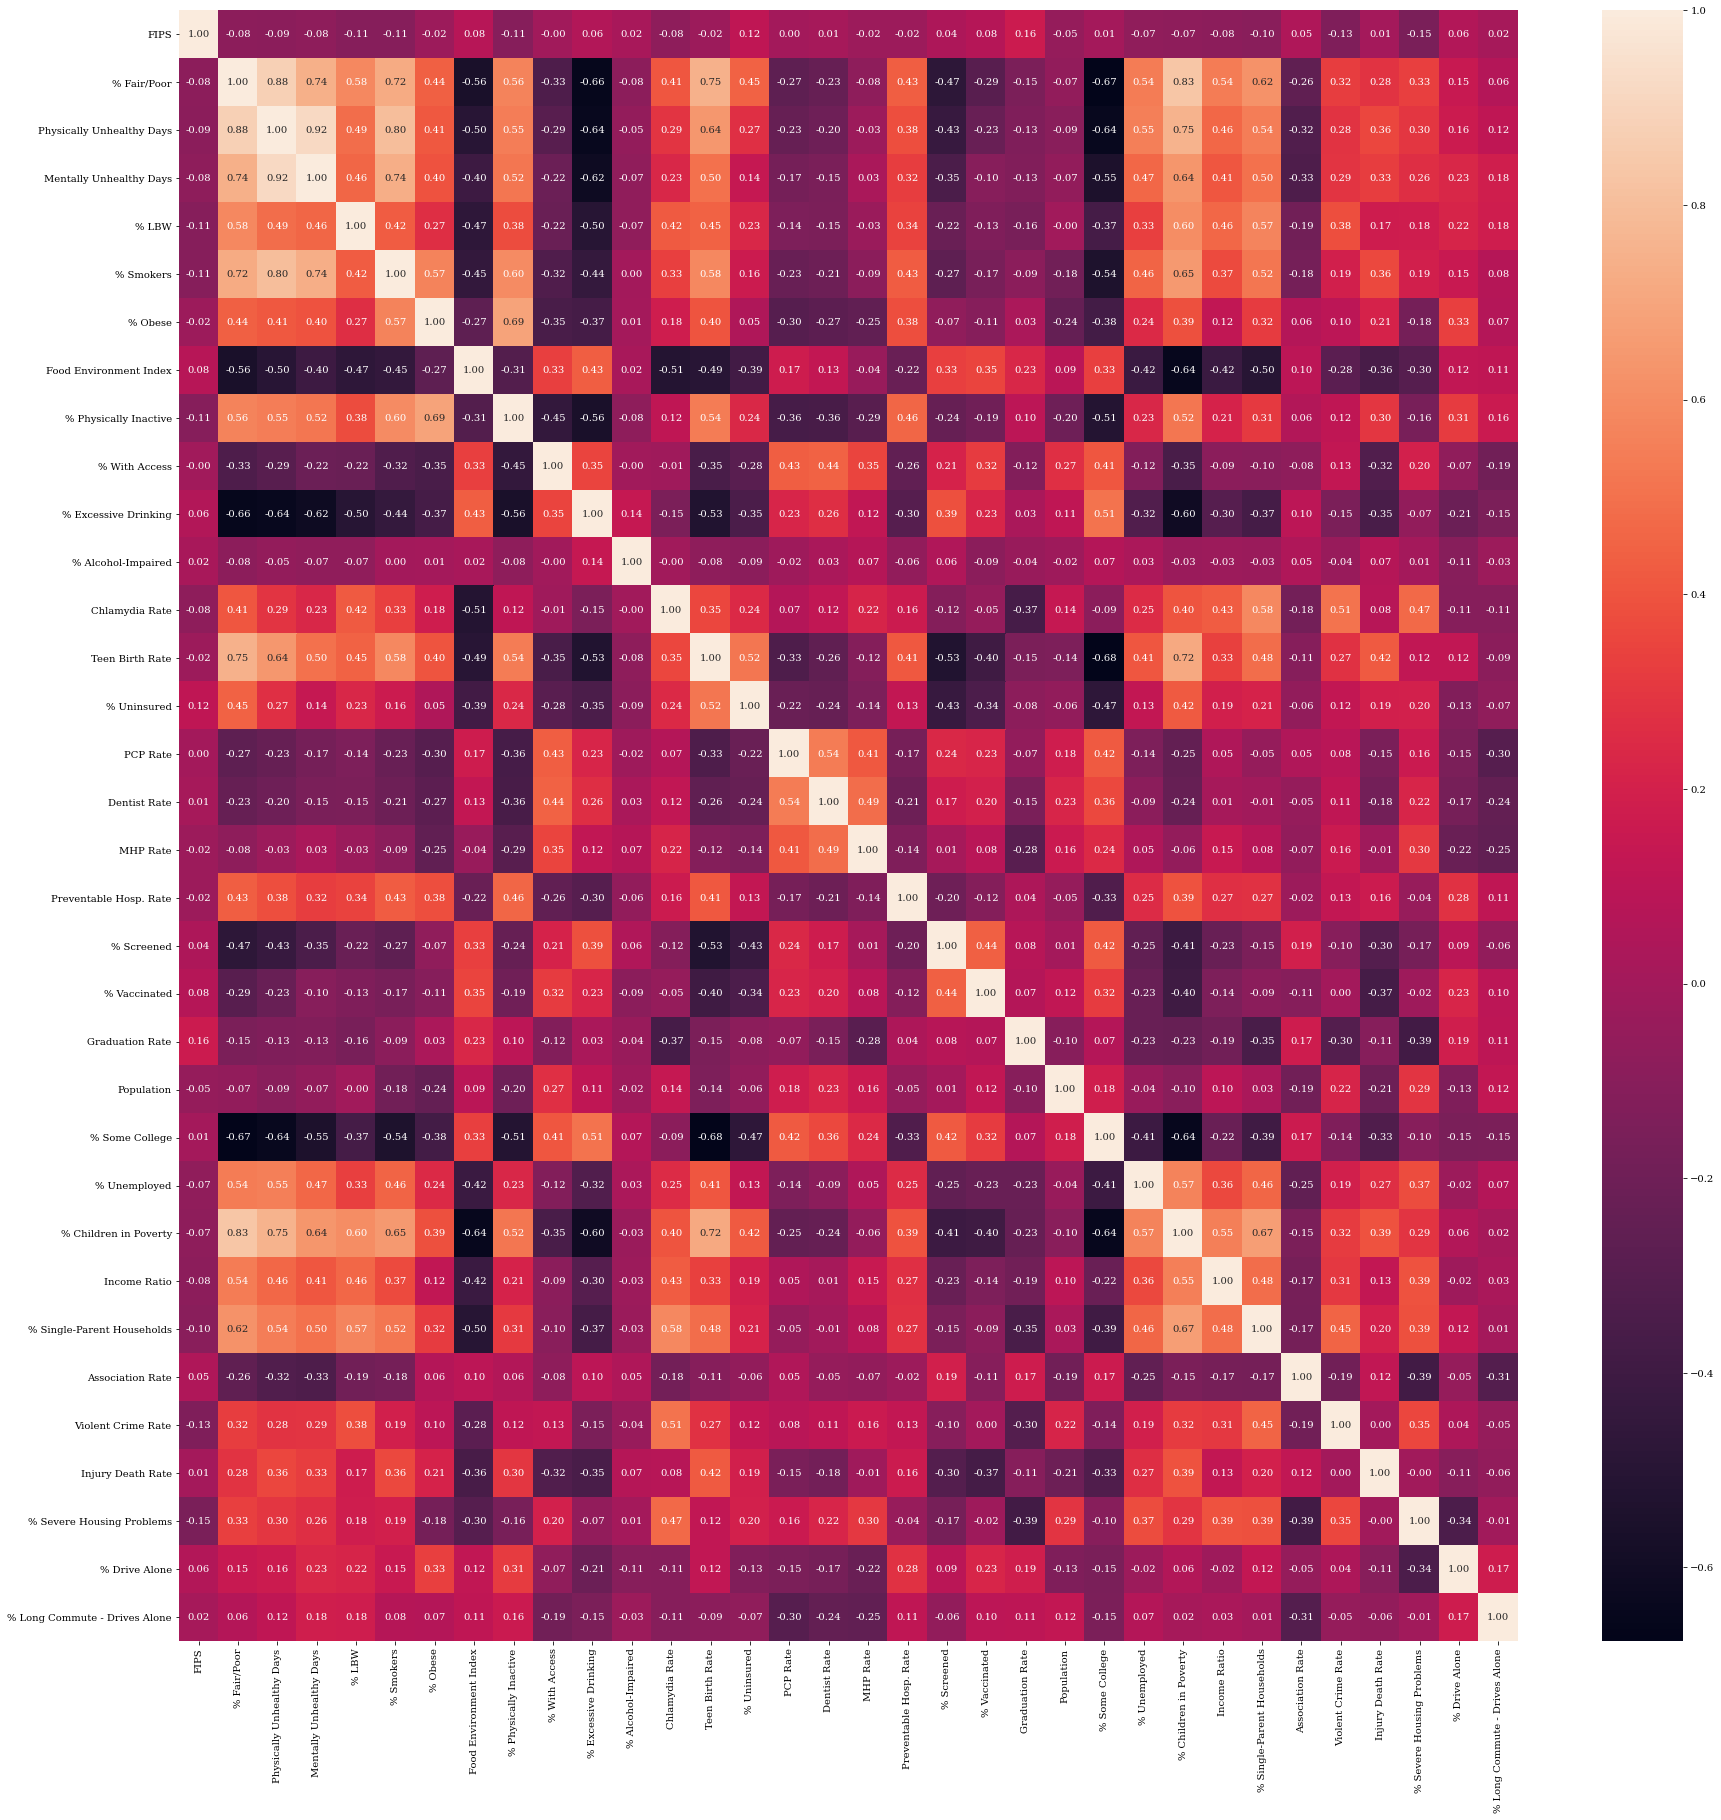

In [7]:
corrMatrix = df2.corr()
plt.rcParams['figure.figsize'] = (30.0, 30.0)
plt.rcParams['font.family'] = "serif"
heatmp = sb.heatmap(corrMatrix, annot=True, cmap='rocket', fmt=".2f")
fig = heatmp.get_figure()
fig.savefig('county_heatmap.png')
plt.show()

In [8]:
df2.shape

(3142, 37)

In [9]:
ratio_df = df2["Dentist Ratio"].str.split(pat=":", expand=True)
df2["Dentists per person"] = pd.to_numeric(ratio_df[0])
df2.drop("Dentist Ratio", axis=1, inplace=True)

In [10]:
ratio_df = df2["PCP Ratio"].str.split(pat=":", expand=True)
df2["PCPs per person"] = pd.to_numeric(ratio_df[0])
df2.drop("PCP Ratio", axis=1, inplace=True)

In [11]:
ratio_df = df2["MHP Ratio"].str.split(pat=":", expand=True)
df2["MHPs per person"] = pd.to_numeric(ratio_df[0])
df2.drop("MHP Ratio", axis=1, inplace=True)

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FIPS                           3142 non-null   int64  
 1   % Fair/Poor                    3142 non-null   int64  
 2   Physically Unhealthy Days      3142 non-null   float64
 3   Mentally Unhealthy Days        3142 non-null   float64
 4   % LBW                          3035 non-null   float64
 5   % Smokers                      3142 non-null   int64  
 6   % Obese                        3142 non-null   int64  
 7   Food Environment Index         3123 non-null   float64
 8   % Physically Inactive          3142 non-null   int64  
 9   % With Access                  3136 non-null   float64
 10  % Excessive Drinking           3142 non-null   int64  
 11  % Alcohol-Impaired             3109 non-null   float64
 12  Chlamydia Rate                 2984 non-null   f

In [13]:
df2.isnull().sum()

FIPS                               0
% Fair/Poor                        0
Physically Unhealthy Days          0
Mentally Unhealthy Days            0
% LBW                            107
% Smokers                          0
% Obese                            0
Food Environment Index            19
% Physically Inactive              0
% With Access                      6
% Excessive Drinking               0
% Alcohol-Impaired                33
Chlamydia Rate                   158
Teen Birth Rate                  144
% Uninsured                        1
PCP Rate                         135
Dentist Rate                      85
MHP Rate                         252
Preventable Hosp. Rate            38
% Screened                        19
% Vaccinated                      16
Graduation Rate                   99
Population                         0
% Some College                     0
% Unemployed                       1
% Children in Poverty              1
Income Ratio                       0
%

In [14]:
colnames = df2.columns

In [15]:
imputer = imp.KNNImputer(n_neighbors=5)

In [16]:
imputer.fit(df2)

KNNImputer()

In [17]:
df_filled = pd.DataFrame(imputer.transform(df2), columns=colnames)
# df_filled.isnull().sum()

In [18]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FIPS                           3142 non-null   float64
 1   % Fair/Poor                    3142 non-null   float64
 2   Physically Unhealthy Days      3142 non-null   float64
 3   Mentally Unhealthy Days        3142 non-null   float64
 4   % LBW                          3142 non-null   float64
 5   % Smokers                      3142 non-null   float64
 6   % Obese                        3142 non-null   float64
 7   Food Environment Index         3142 non-null   float64
 8   % Physically Inactive          3142 non-null   float64
 9   % With Access                  3142 non-null   float64
 10  % Excessive Drinking           3142 non-null   float64
 11  % Alcohol-Impaired             3142 non-null   float64
 12  Chlamydia Rate                 3142 non-null   f

In [19]:
# Standard Scale
df_scaled = pd.DataFrame(pre.StandardScaler().fit_transform(df_filled), columns=colnames)
df_scaled["FIPS"] = FIPS_Series
df3 = df_scaled

In [20]:
df3

,FIPS,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,...,% Single-Parent Households,Association Rate,Violent Crime Rate,Injury Death Rate,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone,Dentists per person,PCPs per person,MHPs per person
0,1001,0.110673,0.389001,0.599601,-0.046100,0.308750,1.277396,-0.229372,1.012940,0.264421,...,-0.701569,-0.167723,0.124956,-0.458848,0.162827,0.844024,0.564013,0.023396,-0.110643,1.684748
1,1003,0.110673,0.249076,0.436841,-0.046100,-0.236706,-0.244628,0.458913,-0.338015,0.394420,...,-0.701569,-0.436956,-0.236368,-0.645707,-0.050697,0.713715,0.805931,-0.426932,-0.545341,-0.352851
2,1005,1.810044,1.648322,1.087881,1.410135,1.126935,2.581988,-1.605941,0.433959,-0.385571,...,2.334699,-0.748698,0.879485,-0.496219,0.162827,0.453096,0.241456,-0.091901,-0.031836,4.283682
3,1007,0.535516,0.668850,0.599601,1.410135,0.581479,1.277396,0.114771,1.784914,-2.032219,...,-0.227152,-0.507806,-0.847430,0.512824,-0.691268,0.844024,1.451046,0.313310,-0.390241,3.760922
4,1009,0.747937,0.808775,1.250641,-0.046100,0.581479,0.407668,0.889091,0.626953,-1.728889,...,-0.227152,-0.677848,1.246122,0.699684,-0.904792,0.974333,2.338078,0.754448,0.740308,3.091901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,-0.526591,-0.590471,-0.702479,0.439311,0.036022,-0.462060,0.200806,0.047972,1.174411,...,-0.891336,-0.536146,0.273736,-0.047756,-0.904792,-0.328759,-0.968134,-0.474137,0.113622,-0.618450
3138,56039,-1.163856,-1.010245,-1.353519,-0.531512,-1.054890,-3.940972,0.717020,-2.653938,1.607739,...,-0.796453,0.611633,-0.558371,-0.907311,0.376351,-1.501542,-1.290691,-0.779090,-0.773379,-0.696804
3139,56041,-0.314170,-0.310622,-0.376959,0.924723,0.036022,-0.027196,-0.143336,-0.338015,0.784415,...,-0.986220,-1.202142,-0.943075,0.438080,-0.691268,-0.328759,-1.048773,-0.761127,-0.031836,-0.675508
3140,56043,-0.314170,-0.450546,-0.702479,-0.531512,-0.509434,-0.462060,0.630984,0.047972,0.827748,...,-0.511803,0.795845,-0.905879,-0.608335,-0.691268,-0.328759,-1.613248,-0.703478,-0.257359,-0.677517


In [21]:
start_time = time.time()
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(contamination=0.03).fit(df3)

# Use predict method which returns 1 for an inlier and -1 for an outlier.
out_ellip = cov.predict(df3)
unique, counts = np.unique(out_ellip, return_counts=True)
print("Outliers using Elliptic Envolope")
print(unique, counts)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Outliers using Elliptic Envolope
[-1  1] [  95 3047]
Total run time = 2.086 seconds


In [22]:
start_time = time.time()
from sklearn.ensemble import IsolationForest

OUTDclf = IsolationForest(n_estimators = 10, contamination=0.03)
OUTDclf.fit(df3)
out_iso =OUTDclf.predict(df3)
unique, counts = np.unique(out_iso, return_counts=True)
print("Outliers using Isolation Forest")
print(unique, counts)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Outliers using Isolation Forest
[-1  1] [  95 3047]
Total run time = 0.092 seconds


In [23]:
start_time = time.time()

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=2, contamination=0.03)
out_local = clf.fit_predict(df3)
unique, counts = np.unique(out_local, return_counts=True)
print("Outliers using Local Outlier Factor")
print(unique, counts)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Outliers using Local Outlier Factor
[-1  1] [  94 3048]
Total run time = 0.243 seconds


In [24]:
# One Class SVM NOT USEFUL - SEE OUTLIERS # = INLIERS #
start_time = time.time()

from sklearn.svm import OneClassSVM
OSVMclf = OneClassSVM(gamma = 'scale').fit(df3)
OSVMclf.score_samples(df3)
out_svm = OSVMclf.predict(df3)
unique, counts = np.unique(out_svm, return_counts=True)
print("Outliers using One Class SVM")
print(unique, counts)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Outliers using One Class SVM
[-1  1] [1572 1570]
Total run time = 1.740 seconds


In [25]:
out = pd.DataFrame()
out["out_ellip"] = out_ellip
out["out_iso"] = out_iso
out["out_local"] = out_local

In [37]:
# Each algorithm identified 95 outliers, but they weren't the same 95. 
out2 = out.replace(-1,0)
out2["out_sum"]  = out2.sum(axis = 1)
out2["out_sum"].value_counts()

3    2936
2     136
1      62
0       8
Name: out_sum, dtype: int64

In [38]:
df4 = df3.merge(out2, left_index=True, right_index=True)


In [39]:
df4.shape


(3142, 41)

In [40]:
df4.head()


,FIPS,% Fair/Poor,Physically Unhealthy Days,Mentally Unhealthy Days,% LBW,% Smokers,% Obese,Food Environment Index,% Physically Inactive,% With Access,...,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone,Dentists per person,PCPs per person,MHPs per person,out_ellip,out_iso,out_local,out_sum
0,1001,0.110673,0.389001,0.599601,-0.046100,0.308750,1.277396,-0.229372,1.012940,0.264421,...,0.162827,0.844024,0.564013,0.023396,-0.110643,1.684748,1,1,1,3
1,1003,0.110673,0.249076,0.436841,-0.046100,-0.236706,-0.244628,0.458913,-0.338015,0.394420,...,-0.050697,0.713715,0.805931,-0.426932,-0.545341,-0.352851,1,1,1,3
2,1005,1.810044,1.648322,1.087881,1.410135,1.126935,2.581988,-1.605941,0.433959,-0.385571,...,0.162827,0.453096,0.241456,-0.091901,-0.031836,4.283682,1,1,1,3
3,1007,0.535516,0.668850,0.599601,1.410135,0.581479,1.277396,0.114771,1.784914,-2.032219,...,-0.691268,0.844024,1.451046,0.313310,-0.390241,3.760922,1,1,1,3
4,1009,0.747937,0.808775,1.250641,-0.046100,0.581479,0.407668,0.889091,0.626953,-1.728889,...,-0.904792,0.974333,2.338078,0.754448,0.740308,3.091901,1,1,1,3


In [41]:
df4["out_sum"].value_counts()

3    2936
2     136
1      62
0       8
Name: out_sum, dtype: int64

In [42]:
df4 = df4[df4["out_sum"]==3]
df4.drop(["out_ellip", "out_iso", "out_local", "out_sum"], axis=1, inplace=True)
df4.shape

(2936, 37)

In [43]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 0 to 3141
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FIPS                           2936 non-null   int64  
 1   % Fair/Poor                    2936 non-null   float64
 2   Physically Unhealthy Days      2936 non-null   float64
 3   Mentally Unhealthy Days        2936 non-null   float64
 4   % LBW                          2936 non-null   float64
 5   % Smokers                      2936 non-null   float64
 6   % Obese                        2936 non-null   float64
 7   Food Environment Index         2936 non-null   float64
 8   % Physically Inactive          2936 non-null   float64
 9   % With Access                  2936 non-null   float64
 10  % Excessive Drinking           2936 non-null   float64
 11  % Alcohol-Impaired             2936 non-null   float64
 12  Chlamydia Rate                 2936 non-null   f

In [44]:
df4["State"] = State_Series
df4["County"] = County_Series

In [45]:
df4.to_csv("Clean_FIPS_Counties.csv")